In [3]:
import sys 
import os

if 'fast_shapelets' not in [el.split('/')[-1] for el in sys.path]:
    curr_path = os.getcwd()
    sys.path.append('/'.join((curr_path.split('/')[:-1])))




In [4]:
from src import get_dataset, FastShapelets
import numpy as np
import matplotlib.pyplot as plt

# Load data

In [5]:
X_train,y_train, X_test, y_test = get_dataset('StarLightCurves')
y_train = y_train-1
y_test = y_test-1

Dataset StarLightCurves loading from cache 



# Binary classification

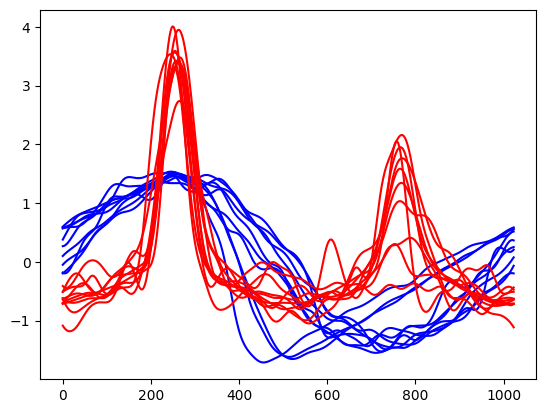

In [6]:
class_0 = X_train[np.where(y_train==0)][:10]
class_2 = X_train[np.where(y_train==1)][:10]
for el in class_0:
  plt.plot(el,color='b')
for el in class_2:
  plt.plot(el,color='r')


In [15]:
train_bin_indices = (y_train ==1) + (y_train ==0)
test_bin_indices = (y_test ==1) + (y_test ==0)

In [16]:
X_train_bin, y_train_bin = X_train[train_bin_indices], y_train[train_bin_indices]
X_test_bin, y_test_bin = X_test[test_bin_indices], y_test[test_bin_indices]

In [20]:
shapelets_len = list(range(100, 600, 50))

In [21]:
fs = FastShapelets(shapelet_lengths =shapelets_len,  cardinality=4, dimensionality=16, r=10, n_jobs=1)

In [22]:
fs.fit(X_train_bin, y_train_bin)

Output()

Computing all shapelets...

Computing shapelet 1/10

Computing collision table...

Computing distances

Finding best shapelet

Computing shapelet 2/10

Computing collision table...

Computing distances

Finding best shapelet

Computing shapelet 3/10

Computing collision table...

Computing distances

Finding best shapelet

Computing shapelet 4/10

Computing collision table...

Computing distances

Finding best shapelet

Computing shapelet 5/10

Computing collision table...

Computing distances

Finding best shapelet

Computing shapelet 6/10

Computing collision table...

Computing distances

Finding best shapelet

Computing shapelet 7/10

Computing collision table...

Computing distances

Finding best shapelet

Computing shapelet 8/10

Computing collision table...

Computing distances

Finding best shapelet

Computing shapelet 9/10

Computing collision table...

Computing distances

Finding best shapelet

Computing shapelet 10/10

Computing collision table...

Computing distances

Finding best shapelet

In [23]:
import pickle
with open('shap_100_600_50_bin.pkl', 'wb') as f :
    pickle.dump(fs.get_shapelets(), f)

In [ ]:
with open('shap_100_600_50_bin.pkl', 'rb') as f :
    fs.fit(shapelets = pickle.load(f))

In [62]:
train_shap = fs.transform(X_train_bin)
test_shap = fs.transform(X_test_bin)

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score


knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(train_shap, y_train_bin)
acc = knn.score(test_shap,y_test_bin)
b_acc = balanced_accuracy_score(y_test_bin, knn.predict(test_shap))
print(f"raw acc : {acc} | balanced acc {b_acc}")

raw acc : 0.9985640436530729 | balanced acc 0.9987075122051909


0.9982768523836876


[Text(0.5, 0.75, 'x[9] <= 1.106\ngini = 0.459\nsamples = 427\nvalue = [152, 275]'),
 Text(0.25, 0.25, 'gini = 0.007\nsamples = 276\nvalue = [1, 275]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 151\nvalue = [151, 0]')]

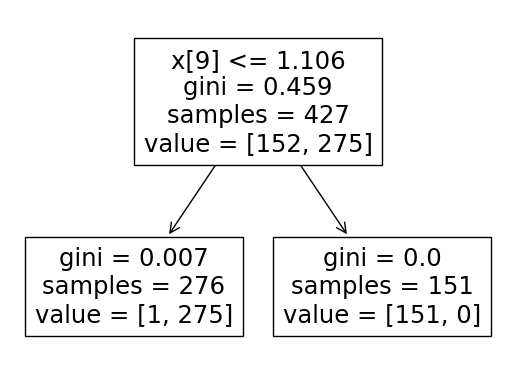

In [28]:
from sklearn import tree
Dtree = DecisionTreeClassifier(max_depth=1)
Dtree.fit(train_shap, y_train_bin)
print(Dtree.score(test_shap,y_test_bin))
tree.plot_tree(Dtree)

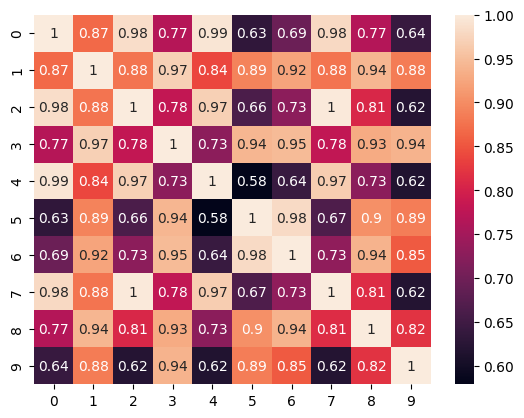

In [64]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

train_features_df = pd.DataFrame(train_shap)

corr_matrix = train_features_df.corr()
fig = sn.heatmap(corr_matrix,annot=True)
plt.show()

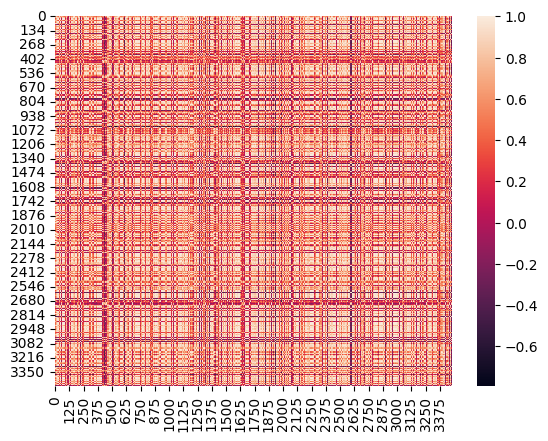

In [30]:
ind_df = pd.DataFrame(test_shap.T)

corr_ind = ind_df.corr()
sn.heatmap(corr_ind)
plt.show()

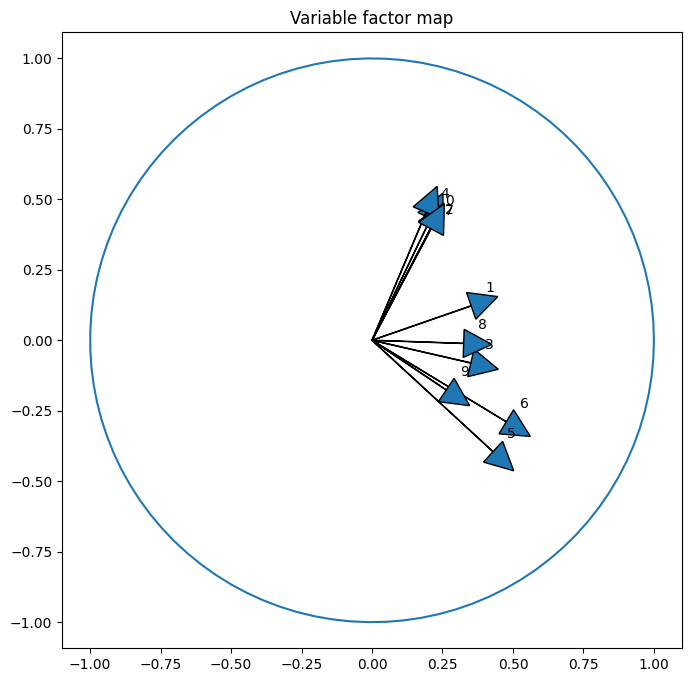

In [66]:
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
 
df = train_features_df
 
n_components = 10
 
# Do the PCA.
pca = PCA(n_components=n_components)
pca.fit_transform(df)


# Plot a variable factor map for the first two dimensions.
(fig, ax) = plt.subplots(figsize=(8, 8))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.1,
             head_length=0.1)

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             df.columns.values[i])


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
ax.set_title('Variable factor map')
plt.savefig('stability_circular.png')
plt.show()

In [33]:
print([fs.shapelets[k].gain for k in fs.shapelets.keys()])

[-0.0014888525986428425, -0.0014888525986428425, -0.0014888525986428425, -0.0014888525986428425, -0.0014888525986428425, -0.0014888525986428425, -0.0014888525986428425, -0.0014888525986428425, -0.0014888525986428425, -0.0014888525986428425]


In [53]:
from src._shapelet import Shapelet

In [61]:
fs.fit(shapelets={i:Shapelet(value=sh) for i,sh in enumerate(shaps)})

In [60]:
fs.get_shapelets()[0].value

array([ 0.824  ,  0.728  ,  0.6353 ,  0.5454 ,  0.4597 ,  0.3777 ,
        0.3    ,  0.2266 ,  0.1575 ,  0.0928 ,  0.0324 , -0.02332,
       -0.0747 , -0.1219 , -0.1647 , -0.2034 , -0.2382 , -0.269  ,
       -0.2961 , -0.3196 , -0.3398 , -0.357  , -0.371  , -0.3828 ,
       -0.3918 , -0.399  , -0.4038 , -0.407  , -0.409  , -0.4092 ,
       -0.4087 , -0.407  , -0.4048 , -0.4019 , -0.3987 , -0.395  ,
       -0.391  , -0.3875 , -0.3835 , -0.38   , -0.3762 , -0.373  ,
       -0.37   , -0.3677 , -0.3655 , -0.3638 , -0.3623 , -0.3616 ,
       -0.361  , -0.3608 , -0.361  , -0.3616 , -0.3625 , -0.3638 ,
       -0.3652 , -0.3667 , -0.3687 , -0.3706 , -0.3728 , -0.375  ,
       -0.3774 , -0.38   , -0.3823 , -0.3848 , -0.3872 , -0.3894 ,
       -0.3916 , -0.3938 , -0.3955 , -0.3972 , -0.3987 , -0.4    ,
       -0.4006 , -0.4011 , -0.4016 , -0.4014 , -0.4011 , -0.4004 ,
       -0.3994 , -0.398  , -0.396  , -0.394  , -0.3916 , -0.389  ,
       -0.386  , -0.3828 , -0.3794 , -0.3757 , -0.3718 , -0.36

In [41]:
with open('shap_100_600_50_bin.pkl', 'rb') as f :
    shapelets=pickle.load(f)
    
fs = FastShapelets().fit(shapelets=shapelets)

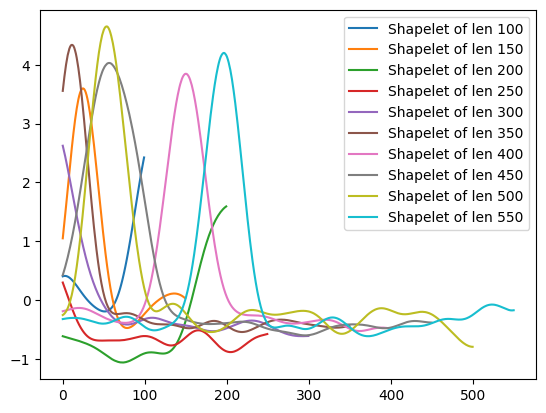

In [42]:
for i,k in enumerate(fs.shapelets.keys()):
  plt.plot(fs.shapelets[k].value,label=f"Shapelet of len {k}")
  plt.legend()

# Stability

In [46]:
shaps = []
for k in range(10):
  fs = FastShapelets(min_shapelet_length=450, max_shapelet_length=451, cardinality=4, dimensionality=16, r=10, n_jobs=1)
  fs.fit(X_train_bin,y_train_bin)
  shaps.append(fs.shapelets[450].value)

Output()

Computing all shapelets...

Computing shapelet 1/1

Computing collision table...

Computing distances

Finding best shapelet

Output()

Computing all shapelets...

Computing shapelet 1/1

Computing collision table...

Computing distances

Finding best shapelet

Output()

Computing all shapelets...

Computing shapelet 1/1

Computing collision table...

Computing distances

Finding best shapelet

Output()

Computing all shapelets...

Computing shapelet 1/1

Computing collision table...

Computing distances

Finding best shapelet

Output()

Computing all shapelets...

Computing shapelet 1/1

Computing collision table...

Computing distances

Finding best shapelet

Output()

Computing all shapelets...

Computing shapelet 1/1

Computing collision table...

Computing distances

Finding best shapelet

Output()

Computing all shapelets...

Computing shapelet 1/1

Computing collision table...

Computing distances

Finding best shapelet

Output()

Computing all shapelets...

Computing shapelet 1/1

Computing collision table...

Computing distances

Finding best shapelet

Output()

Computing all shapelets...

Computing shapelet 1/1

Computing collision table...

Computing distances

Finding best shapelet

Output()

Computing all shapelets...

Computing shapelet 1/1

Computing collision table...

Computing distances

Finding best shapelet

# 3 class

In [67]:
train_tern_indices = train_bin_indices + (y_train==2)
test_tern_indices = test_bin_indices + (y_test==2)
X_train_tern, y_train_tern = X_train[train_tern_indices], y_train[train_tern_indices]
X_test_tern, y_test_tern = X_test[test_tern_indices], y_test[test_tern_indices]


In [68]:
fs = FastShapelets(shapelet_lengths = shapelets_len, cardinality=4, dimensionality=16, r=10)

In [ ]:
fs.fit(X_train_tern,y_train_tern)

Output()

Computing all shapelets...

Computing shapelet 1/10

Computing collision table...

In [25]:
train_shap_tern = fs.transform(X_train_tern)
test_shap_tern = fs.transform(X_test_tern)

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score


knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(train_shap_tern, y_train_tern)
acc = knn.score(test_shap_tern,y_test_tern)
b_acc = balanced_accuracy_score(y_test_tern, knn.predict(test_shap_tern))
print(f"raw acc : {acc} | balanced acc {b_acc}")

raw acc : 0.9985640436530729 | balanced acc 0.9987075122051909


0.9982768523836876


[Text(0.5, 0.75, 'x[9] <= 1.106\ngini = 0.459\nsamples = 427\nvalue = [152, 275]'),
 Text(0.25, 0.25, 'gini = 0.007\nsamples = 276\nvalue = [1, 275]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 151\nvalue = [151, 0]')]

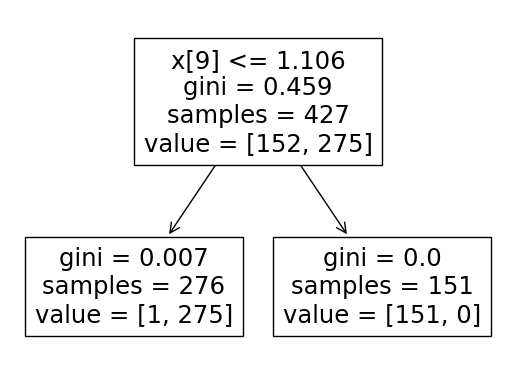

In [28]:
from sklearn import tree
Dtree = DecisionTreeClassifier(max_depth=1)
Dtree.fit(train_shap_tern, y_train_tern)
print(Dtree.score(test_shap_tern,y_test_tern))
tree.plot_tree(Dtree)

Confusion matrix, without normalization
[[118   0  82]
 [  0 186  14]
 [ 62   1 137]]
Normalized confusion matrix
[[0.59  0.    0.41 ]
 [0.    0.93  0.07 ]
 [0.31  0.005 0.685]]


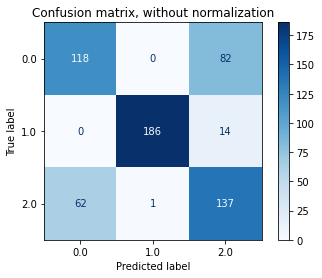

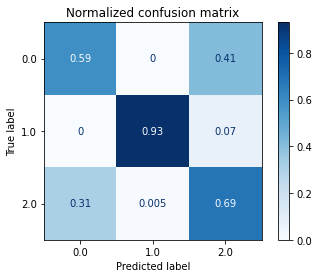

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        knn,
        test_shap,
        y_test_tern,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()


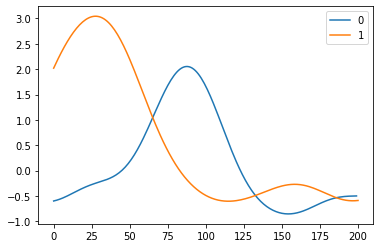

In [40]:
for i,k in enumerate(fs.shapelets.keys()):
  plt.plot(fs.shapelets[k].value,label=str(i))
  plt.legend()

In [ ]:
from sklearn import tree
Dtree = DecisionTreeClassifier(max_depth=2)
Dtree.fit(train_shap, np.hstack((np.zeros(10),np.ones(10))))
print(Dtree.score(test_shap,np.hstack((np.zeros(1177),np.ones(2305)))))
tree.plot_tree(Dtree)